In [29]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Online Learning Applications/Project

Mounted at /gdrive
/gdrive/My Drive/Online Learning Applications/Project


## Environment

In [30]:
import numpy as np

In [31]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [32]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [33]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [34]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

## Advertising

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [36]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.ones(self.n_arms) * 1e3
    self.means_costs = np.ones(self.n_arms) * 1e3
    self.sigmas_clicks = np.ones(self.n_arms)
    self.sigmas_costs = np.ones(self.n_arms)
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    if normalize_y:
      kernel_clicks = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
      kernel_costs = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
    else:
      kernel_clicks = C(1,(1e3,1e4)) * RBF(1,(0.1,1))
      kernel_costs = C(1, (1e3,1e4)) * RBF(1,(0.1,1))
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer)
    self.plot = plot
    self.step = step
    self.step_delay = step_delay

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < self.step_delay or not(self.t % self.step):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1:
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)

      if self.plot:
        plt.figure()
        plt.title("Clicks:" + str(self.t))
        plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
        plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
        plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$n(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

        plt.figure()
        plt.title("Costs:" + str(self.t))
        plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
        plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
        plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$c(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    samples = np.random.normal(self.means_clicks - self.means_costs, np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2))
    return np.argmax(samples)

In [37]:
class GPUCB_Learner(GPTS_Learner):
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms, arms, alpha_clicks, alpha_costs, normalize_y, step, step_delay, n_restarts_optimizer, plot)

  # returns index of the maximum UCB from the arm normal distribution (coefficient for CI of order 1-1/T: 3.0)
  def pull_arm(self):
    upper_bound = self.means_clicks - self.means_costs + 3.0*np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2)
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

## Simulation

In [38]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [39]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [40]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([0.15,0.1,0.1,0.35,0.1])             # bernoulli distributions for the reward functions
opt_rate = p[np.argmax(p*prices)]                 # optimal arm
print("Pricing (optimal price):")
print("idx: " + str(np.argmax(p*prices)) + "  price: " + str(prices[np.argmax(p*prices)]) + "  rate: " + str(opt_rate) + "  price*rate: " + str(opt_rate*prices[np.argmax(p*prices)]))

Pricing (optimal price):
idx: 3  price: 8  rate: 0.35  price*rate: 2.8


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768


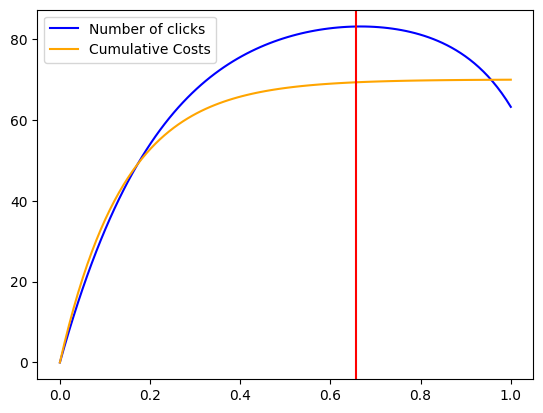

In [41]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid = bids[np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))]
fig, ax = plt.subplots()
ax.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
ax.legend(["Number of clicks", "Cumulative Costs"])
ax.axvline(opt_bid,c='red')
print("Advertising (optimal bid):")
print("idx: " + str(np.argmax(opt_rate*prices[np.argmax(p*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid) + "  clicks-costs: " + str(clicks(opt_bid)-costs(opt_bid)))

In [42]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [43]:
# experiments
n_experiments = 100
step = 10
gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []
DEBUG = False

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs)
  pricing_learner_gpts = TS_Pricing_Learner(n_arms = n_prices,
                                            prices = prices)
  pricing_learner_gpucb = TS_Pricing_Learner(n_arms = n_prices,
                                            prices = prices)
  gpts_learner = GPTS_Learner(n_arms = n_bids,
                              arms = bids,
                              alpha_clicks = sigma_clicks,
                              alpha_costs = sigma_costs,
                              step = step,
                              #normalize_y = True,
                              #n_restarts_optimizer = 1,
                              #plot = True,
                              step_delay = 0)
  gpucb_learner = GPUCB_Learner(n_arms = n_bids,
                                arms = bids,
                                alpha_clicks = sigma_clicks,
                                alpha_costs = sigma_costs,
                                step = step,
                                #normalize_y = True,
                                #plot = True,
                                #n_restarts_optimizer = 1,
                                step_delay = 0)

  gpts_daily_pricing_reward = np.array([])
  gpucb_daily_pricing_reward = np.array([])


  for t in range(0,T):  # cycle on time horizon

    # GPTS
    pulled_bid_ts = gpts_learner.pull_arm()
    reward_click_ts, reward_cost_ts = env.bidding_round(pulled_bid_ts)
    gpts_learner.update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])
    for k in range(reward_click_ts):
      pulled_price = pricing_learner_gpts.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      pricing_learner_gpts.update(pulled_price, reward_price)
    gpts_daily_pricing_reward = np.append(gpts_daily_pricing_reward,(reward_click_ts>0)*np.sum(pricing_learner_gpts.collected_rewards[-reward_click_ts:]))

    if DEBUG:
      if (t>step):
        print(gpts_learner.gp_clicks.kernel_.get_params())
        print(gpts_learner.gp_costs.kernel_.get_params())

    # GPUCB
    pulled_bid_ucb = gpucb_learner.pull_arm()
    reward_click_ucb, reward_cost_ucb = env.bidding_round(pulled_bid_ucb)
    gpucb_learner.update(pulled_bid_ucb, [reward_click_ucb,reward_cost_ucb])
    for k in range(reward_click_ucb):
      pulled_price = pricing_learner_gpucb.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      pricing_learner_gpucb.update(pulled_price, reward_price)
    gpucb_daily_pricing_reward = np.append(gpucb_daily_pricing_reward,(reward_click_ucb>0)*np.sum(pricing_learner_gpucb.collected_rewards[-reward_click_ucb:]))

  gpts_rewards_per_experiment.append(gpts_daily_pricing_reward - gpts_learner.collected_costs)
  gpucb_rewards_per_experiment.append(gpucb_daily_pricing_reward - gpucb_learner.collected_costs)



100%|██████████| 100/100 [39:19<00:00, 23.60s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

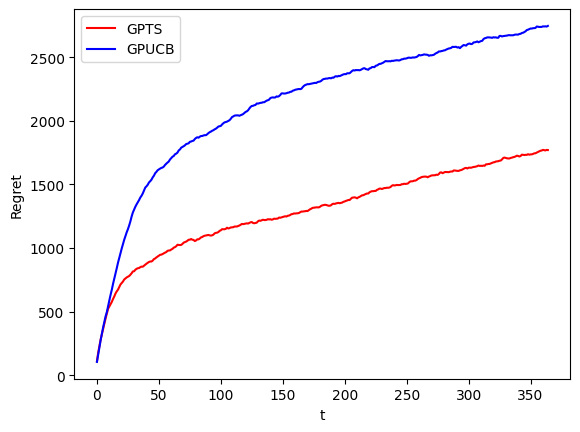

In [44]:
opt = opt_rate*prices[np.argmax(p*prices)]*clicks(opt_bid) - costs(opt_bid)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["GPTS","GPUCB"])
plt.show

In [45]:
np.savetxt('part3_gpts_indep.txt', gpts_rewards_per_experiment)
np.savetxt('part3_gpucb_indep.txt', gpucb_rewards_per_experiment)

In [46]:
#gpts_rewards_per_experiment = np.loadtxt('part3_gpts_indep.txt')
#gpucb_rewards_per_experiment = np.loadtxt('part3_gpucb_indep.txt')

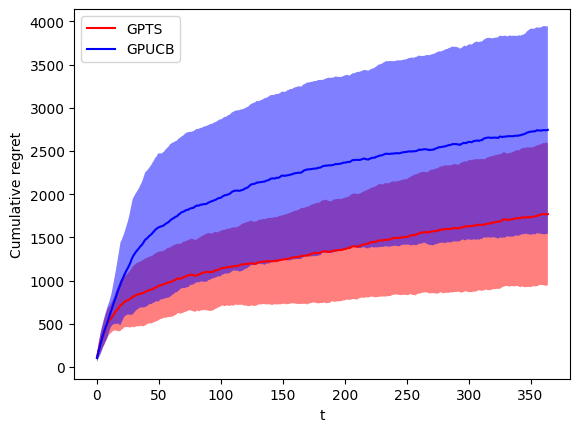

In [47]:
plt.figure()
plt.ylabel("Cumulative regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(opt - gpts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(opt - gpts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(opt - gpucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(opt - gpucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

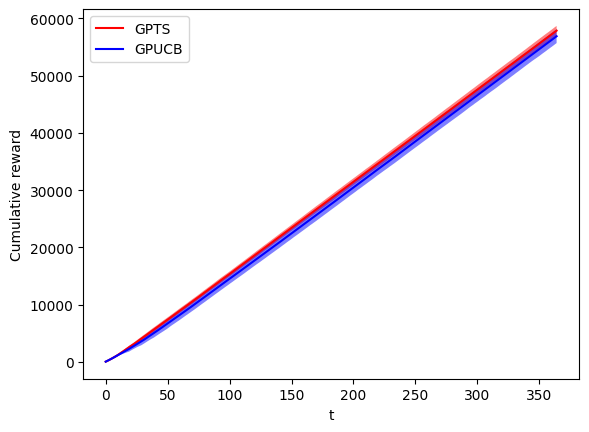

In [48]:
plt.figure()
plt.ylabel("Cumulative reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(gpucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(gpts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(gpts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(gpucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(gpucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

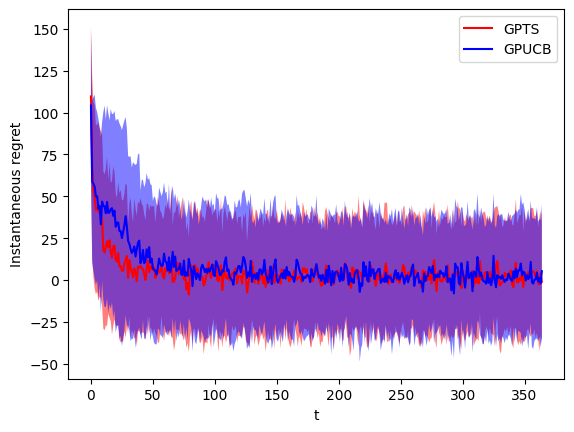

In [49]:
plt.figure()
plt.ylabel("Instantaneous regret")
plt.xlabel("t")
plt.plot(np.mean(opt - gpts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(opt - gpucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(opt - gpts_rewards_per_experiment, axis=0)
ts_metric= np.mean(opt - gpts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(opt - gpucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(opt - gpucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

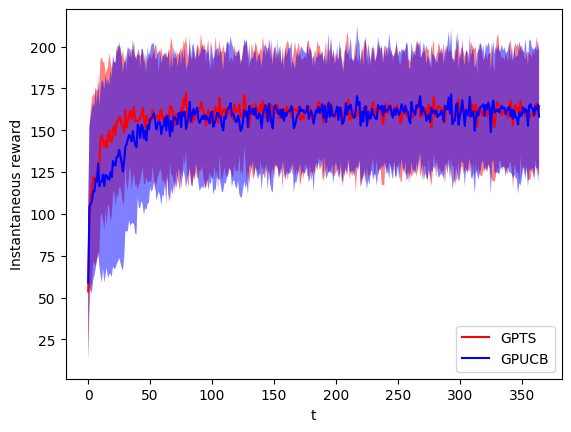

In [50]:
plt.figure()
plt.ylabel("Instantaneous reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(gpts_rewards_per_experiment, axis=0)
ts_metric= np.mean(gpts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(gpucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(gpucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

## Plots of last experiment

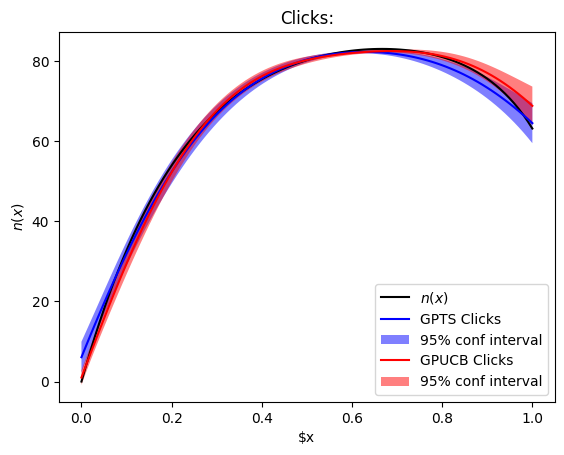

In [51]:
plt.figure()
plt.title("Clicks:")
plt.plot(bids, clicks(bids), 'black', label = r'$n(x)$')
plt.plot(bids, gpts_learner.means_clicks, 'b-', label = u'GPTS Clicks')
plt.fill(np.concatenate([bids, bids[::-1]]),
        np.concatenate([gpts_learner.means_clicks - 1.96 * gpts_learner.sigmas_clicks , (gpts_learner.means_clicks + 1.96 * gpts_learner.sigmas_clicks)[::-1]]),
        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
plt.plot(bids, gpucb_learner.means_clicks, 'r-', label = u'GPUCB Clicks')
plt.fill(np.concatenate([bids, bids[::-1]]),
        np.concatenate([gpucb_learner.means_clicks - 1.96 * gpucb_learner.sigmas_clicks , (gpucb_learner.means_clicks + 1.96 * gpucb_learner.sigmas_clicks)[::-1]]),
        alpha = .5, fc = 'r', ec = 'None', label = '95% conf interval')
plt.xlabel('$x')
plt.ylabel('$n(x)$')
plt.legend(loc = 'lower right')
plt.show()

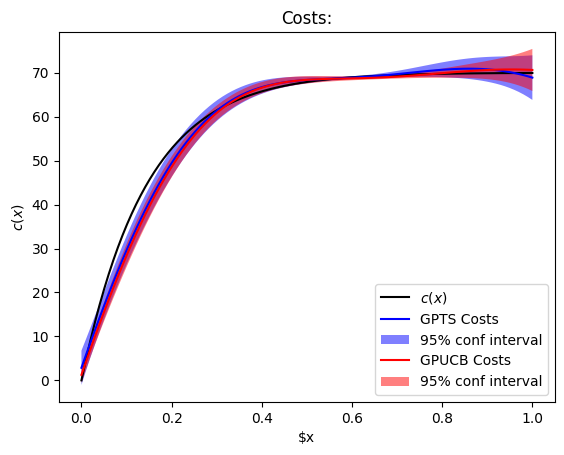

In [52]:
plt.figure()
plt.title("Costs:")
plt.plot(bids, costs(bids), 'black', label = r'$c(x)$')
plt.plot(bids, gpts_learner.means_costs, 'b-', label = u'GPTS Costs')
plt.fill(np.concatenate([bids, bids[::-1]]),
        np.concatenate([gpts_learner.means_costs - 1.96 * gpts_learner.sigmas_costs , (gpts_learner.means_costs + 1.96 * gpts_learner.sigmas_costs)[::-1]]),
        alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
plt.plot(bids, gpucb_learner.means_costs, 'r-', label = u'GPUCB Costs')
plt.fill(np.concatenate([bids, bids[::-1]]),
        np.concatenate([gpucb_learner.means_costs - 1.96 * gpucb_learner.sigmas_costs , (gpucb_learner.means_costs + 1.96 * gpucb_learner.sigmas_costs)[::-1]]),
        alpha = .5, fc = 'r', ec = 'None', label = '95% conf interval')
plt.xlabel('$x')
plt.ylabel('$c(x)$')
plt.legend(loc = 'lower right')
plt.show()